<a href="https://colab.research.google.com/github/albim72/BOOTCAMP_PYTHON_1/blob/main/Overfit_Underfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [31]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ueem58cy
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ueem58cy


In [32]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [33]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorflow_logs"
shutil.rmtree(logdir, ignore_errors=True)

zbiór Higgsa -> 11000000 elementów (każdy 28 cech) + binarna etykieta danych

In [34]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz','http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [35]:
FEATURES = 28

In [36]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type="GZIP")

In [37]:
#powyższa funkcja zwraca listę skalarów dla każdego rekrodu. Jak przepakować tę listę do pary (wektor_funkcji,etykieta)???
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features,label

In [38]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


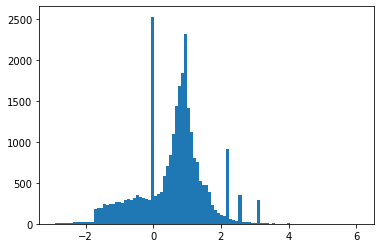

In [39]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)

In [40]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN/BATCH_SIZE

In [41]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [42]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [43]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

DEMONSTRACJA NADMIERNEGO DOPASOWANIA

In [44]:
#Procedura szkolenia
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate = 1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

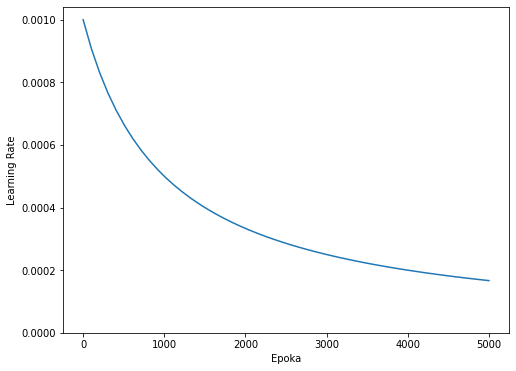

In [45]:
step  = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoka')
_ = plt.ylabel("Learning Rate")

In [46]:
def get_callbacks(name):
  return [
      tfdocs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
      tf.keras.callbacks.TensorBoard(logdir/name)
  ]

In [47]:
from tensorflow.python.training.saver import metrics
def compile_and_fit(model,name,optimizer=None, max_epochs = 10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                    tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                    'accuracy'
                ])
  
  model.summary()

  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epochs,
      validation_data = validate_ds,
      callbacks = get_callbacks(name),
      verbose = 0
  )
  return history


            

MAŁY MODEL

In [48]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu', input_shape = (FEATURES,)),
    layers.Dense(1)
])

In [49]:
size_histories = {}

In [50]:
size_histories['Tiny'] = compile_and_fit(tiny_model,'sizes/Tiny')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5040,  binary_crossentropy:0.7461,  loss:0.7461,  val_accuracy:0.4980,  val_binary_crossentropy:0.7240,  val_loss:0.7240,  
....................................................................................................
Epoch: 100, accuracy:0.6023,  binary_crossentropy:0.6231,  loss:0.6231,  val_accuracy:0.5990,  val_binary_crossentropy:0.6264,  val_loss:0.6264,  
..........................................................

(0.5, 0.7)

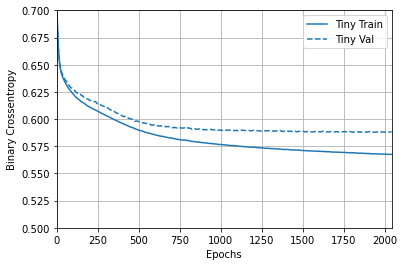

In [51]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [54]:
small_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16,activation='elu'),
    layers.Dense(1)
])

size_histories['Small']=compile_and_fit(small_model,'sizes/Small')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                464       
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4825,  binary_crossentropy:0.7027,  loss:0.7027,  val_accuracy:0.4760,  val_binary_crossentropy:0.6996,  val_loss:0.6996,  
....................................................................................................
Epoch: 100, accuracy:0.6435,  binary_crossentropy:0.6002,  loss:0.6002,  

In [55]:
medium_model = tf.keras.Sequential([
    layers.Dense(64,activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64,activation='elu'),
    layers.Dense(64,activation='elu'),
    layers.Dense(1)
])

size_histories['Medium']=compile_and_fit(medium_model,'sizes/Medium')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                1856      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4991,  binary_crossentropy:0.6841,  loss:0.6841,  val_accuracy:0.5260,  val_binary_crossentropy:0.6657,  val_loss:0.6657,  
....................................

In [56]:
large_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(1)
])

size_histories['large']=compile_and_fit(large_model,'sizes/large')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 512)               14848     
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dense_21 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4959,  binary_crossentropy

Text(0.5, 0, 'Epoki [skala log]')

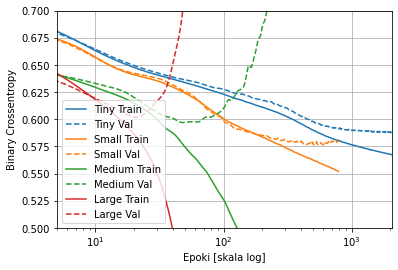

In [57]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5,max(plt.xlim())])
plt.ylim([0.5,0.7])
plt.xlabel("Epoki [skala log]")

In [59]:
#kopiowanie dzienników - > logów
shutil.rmtree(logdir/'regularies/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny',logdir/'regularies/Tiny')

PosixPath('/tmp/tmph1_f34xs/tensorflow_logs/regularies/Tiny')

In [60]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [ ]:
#regularyzacja wagi L2
l2_model = tf.keras.Sequential([
    
])